# A Primer on RTT Localization CRBs

With reference to standard TDOAs, one may choose to localize via return trip timings (RTTs). This is **not** the same as ranging (at least not exactly) as is used in standard GPS systems, but instead involves at least a single 'bounce'. Here we will derive the CRB for this specific single bounce scenario, although multiple bounces should be easily extended from this example.

## Measurement of Range

In the single bounce scenario, the signal travels from the emitter (here denoted as $E$) and reaches the unknown *reflector* (here denoted as $X$), then to the receiver/sensor (here denoted as $S$). As such the ranging measurement (after conversions from RTT) is as follows:

$$
r = |X - S| + |X - E|
$$

where the above variables are all vectors representing the respective positions. Here we have not assumed that the emitter is the same as the receiver/sensor.

Note that the form of this is very similar to the TDOA range measurement:

$$
r = |X - S_2| - |X - S_1|
$$

where the two $s_i$ represent the pair of sensors/receivers. Hence it is likely that the final form can be worked out in almost identical way.



## Differentials of Range

In order to calculate the CRB, we need to differentiate the range with respect to the spatial dimensions. 

It is easier to see how to perform the differentiation if the explicit components are written out:

\begin{align}
r &= \left( (x-S_x)^2 + (y-S_y)^2 + (z-S_z)^2 \right)^{1/2} + \left( (x-E_x)^2 + (y-E_y)^2 + (z-E_z)^2 \right)^{1/2} \\
&= \mu + \nu
\end{align}

Differentiating each part $\mu$ and $\nu$, we obtain

$$
\frac{\partial \mu}{\partial x_i} = \frac{X_i - S_i}{\mu}
$$

$$
\frac{\partial \nu}{\partial x_i} = \frac{X_i - E_i}{\nu}
$$

where $i \in \{0,1,2\}$, corresponding to the $x,y,z$ components.

Then

\begin{align}
\frac{\partial r}{\partial x_i} &= \frac{\partial \mu}{\partial x_i} + \frac{\partial \nu}{\partial x_i} \\
&= \frac{X_i - S_i}{\mu} + \frac{X_i - E_i}{\nu}
\end{align}

Note that the convention of $|X-S|$ or $|S-X|$ does not matter; the reader is welcome to confirm this.

At this point, the CRB derivation follows the TDOA one, with each of these terms adding to our 'measurement list'. Explicitly, we define the matrix

\begin{equation}
R = \begin{bmatrix}
\frac{X_x - S^{(0)}_x}{\mu^{(0)}} + \frac{X_x - E_x}{\nu} & \frac{X_x - S^{(1)}_x}{\mu^{(1)}} + \frac{X_x - E_x}{\nu} & ...\\
\frac{X_y - S^{(0)}_y}{\mu^{(0)}} + \frac{X_y - E_y}{\nu} & \frac{X_y - S^{(1)}_y}{\mu^{(1)}} + \frac{X_y - E_y}{\nu} & ...\\
\frac{X_z - S^{(0)}_z}{\mu^{(0)}} + \frac{X_z - E_z}{\nu} & \frac{X_z - S^{(1)}_z}{\mu^{(1)}} + \frac{X_z - E_z}{\nu} & ...\\
\end{bmatrix}
\end{equation}

where the superscript represents the *measurement index*, so there for $N$ measurements the matrix R should have $N$ columns. Here we have assumed a stationary emitter, and as such there is no dependence on the measurement index for $E$, but the general form of the equation is evidently unchanged even if the emitter is moving.

Then the Fisher Information Matrix is defined by

\begin{equation}
F = R \sigma R^T
\end{equation}

with $\sigma$ representing the error matrix of the measurements.

## Accounting for Processing Delays

In any scenario other than a simple reflector or re-broadcaster, there is likely to be some form of processing delay between the receipt of the original signal and the transmission to the final receiver. Hence, the actual form of the range measurement would likely be

\begin{equation}
r = |X - S| + |X - E| + \epsilon
\end{equation}

where $\epsilon$ is some constant representing the delay. Note that the form of this equation allows us to assume that it encompasses all forms of constant (non-time-dependent) delays. We may also assume that the processing delay is not exactly constant, but rather normally-distributed around some mean i.e. $\epsilon \rightarrow N(\epsilon, \sigma_\epsilon)$.

We would like to consider the case where the value $\epsilon$ is unknown; any known value should be a statistical error and can be easily removed. Heuristically, it should be possible to at least detect the presence of the unknown $\epsilon$ by taking measurements at different *geometries*. In particular, it should require at least 3 measurements to expose this mismatch in the model.

Let's consider a simple example with our reflector at $(0,0,0)$, and our TX/RX at 4 corners of a square.

Grid search took 0.532796 seconds.


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

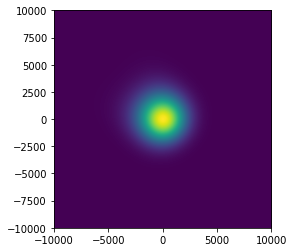

In [17]:
from plotRoutines import *
from localizationRoutines import *
import numpy as np

x = np.array([0,0,0]) # Reflector at centre
t = np.array([-10e3, 10e3, 0]) # Transmitter at top left
r = np.array([[-10e3, -10e3, 0], # Receivers at 3 measurements on other 3 corners
              [10e3, -10e3, 0],
              [10e3, 10e3, 0]])
# r = t.copy() # For testing with tx=rx

# Define some errors
toa_sigma_list = np.zeros(r.shape[0]) + 1e-5

# Calculate the measurements
toa_list = np.linalg.norm(r - x, axis=1) + np.linalg.norm(t - x)
toa_list = toa_list / 299792458.0

# Make a grid
gridside = 20e3
gridx = np.arange(-10e3, -10e3 + gridside, 10)
gridy = np.arange(-10e3, -10e3 + gridside, 10)
meshx, meshy = np.meshgrid(gridx, gridy)
grid_list = np.vstack((meshx.flatten(),meshy.flatten(),np.zeros(meshx.size))).T # Reshape into rows of points

# Perform the localization
cost_grid = gridSearchRTT(t, r, toa_list, toa_sigma_list, grid_list, verb=True)

# Plot
plotHeatmap(np.exp(-cost_grid.reshape(meshx.shape)), gridx[0], gridy[0], gridside, gridside)


Now we can include an unknown, constant delay but continue to model it as if there were none:

Grid search took 0.495471 seconds.


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

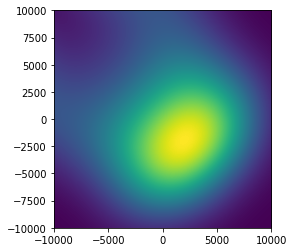

In [24]:
toa_list = np.linalg.norm(r - x, axis=1) + np.linalg.norm(t - x)
toa_list = toa_list / 299792458.0
toa_list = toa_list + 1e-5

# Relocalize
delay_cost_grid = gridSearchRTT(t, r, toa_list, toa_sigma_list, grid_list, verb=True)

# In order to see the exponentiated errors (which are much larger now due to the constant) we have to scale down
scaleDown = 1e-1
scaled_grid = delay_cost_grid * scaleDown

# Plot
plotHeatmap(np.exp(-scaled_grid.reshape(meshx.shape)), gridx[0], gridy[0], gridside, gridside)

## Correcting for the Unknown Delay

It is clear that the unknown delay pushes the localized position away from the true one. With a greater delay offset error, the solution will be even further. More importantly, we can observe in the noiseless scenario that the final position has, in fact, a non-zero cost associated to its position. In particular, the best-fit position's cost will grow with increasing delay error. As such, it seems prudent to iterate over a range of delay values in order to obtain the maximum likelihood, minimum-variance solution for the position, when the delay itself is an unknown constant.

Grid search took 0.497942 seconds.
Grid search took 0.496646 seconds.
Grid search took 0.55446 seconds.
Grid search took 0.483496 seconds.
Grid search took 0.480139 seconds.
Grid search took 0.478399 seconds.


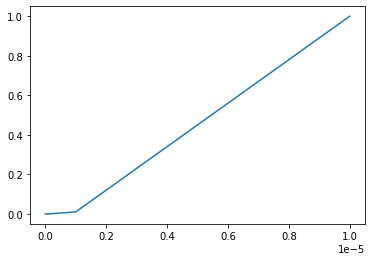

In [25]:
delayErrors = np.array([0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5])
bestCosts = np.zeros(delayErrors.size)

for i in range(delayErrors.size):
    delay = delayErrors[i]
    
    toa_list = np.linalg.norm(r - x, axis=1) + np.linalg.norm(t - x)
    toa_list = toa_list / 299792458.0
    toa_list = toa_list + delay

    # Relocalize
    delay_cost_grid = gridSearchRTT(t, r, toa_list, toa_sigma_list, grid_list, verb=True)
    
    # Solution point cost
    bestCosts[i] = np.min(delay_cost_grid)
    
plt.figure()
plt.plot(delayErrors,bestCosts)
